In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

import ROOT
from ROOT import TFile, TH1F, TCanvas, TMath,TLine, TH1, TLegend
import copy
import array
ROOT.gStyle.SetOptStat(0)
ROOT.disableJSVis()
ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetBarWidth(1);
ROOT.gStyle.SetHistLineWidth(1);
import sys
sys.path.append("/eos/home-x/xuyan/TrijetProj/TrijetAna_Main/ZprimeAna/utiles")
from CMSStyle import CMS_lumi

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import seaborn as sns

print(sns.__version__)

plt.rcParams['figure.figsize'] = (12, 10)  # Set the default figure size
plt.rcParams['legend.fontsize'] = 20  # Set the default font size for legends
plt.rcParams['axes.labelsize'] = 14  # Set the default font size for axis labels (x and y)
plt.rcParams['axes.titlesize'] = 16  # Set the default font size for the plot title
plt.rcParams['xtick.labelsize'] = 12  # Set the default font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 12  # Set the default font size for y-tick labels
plt.rcParams['lines.linewidth'] = 1.5  # Set the default line width
plt.rcParams['lines.markersize'] = 8  # Set the default marker size

Welcome to JupyROOT 6.30/02


2024-03-04 16:00:56.764285: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 16:00:57.270578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.13.2


In [ ]:
print(41938/TMath.Sqrt(11435))
print(40769/TMath.Sqrt(6621))
print(31350/TMath.Sqrt(2703))

In [18]:
cl = 0
pds = []

df_tri_class2 = None
df_tri_class4SB = None

# for s in ["tri"]:
#     for c in ["class1","class3"]:
for s in ["tri","quad"]:
    for c in ["class1","class2","class3","class4_dataSB"]:
        flat_tree = uproot.open(f"Tree_{s}_presel_lowq2_{c}.root")['Events']
        df_temp = None
        df_tree = flat_tree.arrays(library='pd')
        if c != "class4_dataSB":
            df_tree = df_tree[(df_tree["BCand_mass_fullfit"] > 5.0) & (df_tree["BCand_mass_fullfit"] < 5.6)]
        if (c == "class4_dataSB" or c == "class2") and s == "tri":
            df_temp = df_tree.sample(frac=1).reset_index(drop=True)[:50000]
            if c == "class2" and s == "tri":
                df_tri_class2 = df_tree.sample(frac=1).reset_index(drop=True)
            if c == "class4_dataSB" and s == "tri":
                df_tri_class4SB = df_tree.sample(frac=1).reset_index(drop=True)
                print("selecting----->",s, c, len(df_tri_class4SB))
        else:
            df_temp = df_tree
        
        print(s, c, len(df_temp))
        num_rows, num_columns = df_temp.shape
        df_temp["label"] = np.ones(num_rows)
#         if (s == "KEE" and c == "class1") or (s == "KEE" and c == "class3"):
#             df["label"] = 0
#         elif (s == "triplets" and c == "class3") or (s == "quadruplets" and c == "class1"):
#             df["label"] = 1
#         else:
#             df["label"] = 2
        df_temp["label"] = cl
        df_temp['label_traning'] = -99
        df_temp['BCand_sigImpact_llKs'] = -99
        cl+=1
        pds.append(df_temp)
    
     
df_tri_class2["label"] = 1
df_tri_class2['label_traning'] = 1
df_tri_class2['BCand_sigImpact_llKs'] = -99
df_tri_class2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_tri_class2 = df_tri_class2.dropna()

df_tri_class4SB["label"] = 3
df_tri_class4SB['label_traning'] = 3
df_tri_class4SB['BCand_sigImpact_llKs'] = -99
df_tri_class4SB.replace([np.inf, -np.inf], np.nan, inplace=True)
df_tri_class4SB = df_tri_class4SB.dropna()

        
df = pd.concat(pds, axis = 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
# print(df)

# df = df[df['BCand_evt_nQuad'] < 1]
label_traning = 0
for icl in range(0,8):
    sumN = sum(df["label"] == icl)
    print(sumN)
    if sumN != 0:
        df.loc[df["label"] == icl, "label_traning"] = label_traning
        label_traning += 1

# plt.hist(df[df["label"] == 3]['BCand_sigImpact_llKs'], bins=100, range=(0,0.0001), alpha=0.75, color='blue', edgecolor='black')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of y_label')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

y = df["label_traning"]

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

print("-------------",len(df_tri_class4SB))
X_testforplot = pd.concat([X_test,df_tri_class2,df_tri_class4SB], axis = 0)
print(len(X_testforplot), len(X_test), len(df_tri_class2), len(df_tri_class4SB))

X_train = X_train.drop(columns=["label",'label_traning',"BCand_mass_fullfit",'BCand_mll_fullfit_norm',"BCand_mll_fullfit","BCand_fit_l1_pt","BCand_fit_l2_pt","BCand_fit_trk1_pt","BCand_fit_trk2_pt","BCand_fit_pt"])
X_test = X_test.drop(columns=["label",'label_traning',"BCand_mass_fullfit",'BCand_mll_fullfit_norm',"BCand_mll_fullfit","BCand_fit_l1_pt","BCand_fit_l2_pt","BCand_fit_trk1_pt","BCand_fit_trk2_pt","BCand_fit_pt"])
df_tri_class2 = df_tri_class2.drop(columns=["BCand_mass_fullfit",'BCand_mll_fullfit_norm',"BCand_mll_fullfit","BCand_fit_l1_pt","BCand_fit_l2_pt","BCand_fit_trk1_pt","BCand_fit_trk2_pt","BCand_fit_pt"])
df_tri_class4SB = df_tri_class4SB.drop(columns=["BCand_mass_fullfit",'BCand_mll_fullfit_norm',"BCand_mll_fullfit","BCand_fit_l1_pt","BCand_fit_l2_pt","BCand_fit_trk1_pt","BCand_fit_trk2_pt","BCand_fit_pt"])
# X_train = X_train.drop(columns=['BCand_evt_nTri', 'BCand_evt_nQuad'])
# X_test = X_test.drop(columns=['BCand_evt_nTri', 'BCand_evt_nQuad'])
# X_train = X_train.drop(columns=['BCand_sigImpact_llKs'])
# X_test = X_test.drop(columns=['BCand_sigImpact_llKs'])
# X_train = X_train.drop(columns=['BCand_fit_trk2_pt_norm','BCand_MomenAsym_lltrk2','BCand_MomenAsym_llKs','BCand_iso04_trk2_norm','BCand_sigImpact_lltrk2',
#                     'BCand_dR_l1trk2','BCand_dR_l2trk2','BCand_dR_trk1trk2','BCand_dz_l1trk2','BCand_dz_l2trk2','BCand_dz_trk1trk2'])
# X_test = X_test.drop(columns=['BCand_fit_trk2_pt_norm','BCand_MomenAsym_lltrk2','BCand_MomenAsym_llKs','BCand_iso04_trk2_norm','BCand_sigImpact_lltrk2',
#                     'BCand_dR_l1trk2','BCand_dR_l2trk2','BCand_dR_trk1trk2','BCand_dz_l1trk2','BCand_dz_l2trk2','BCand_dz_trk1trk2'])

# BCand_sigImpact_llKs'

print(X_train.columns, len(X_train))
print(X.columns, len(X))

tri class1 52341
tri class2 50000
tri class3 6391
selecting-----> tri class4_dataSB 392913
tri class4_dataSB 50000
quad class1 35601
quad class2 8151
quad class3 3781
quad class4_dataSB 24457
52324
49977
6389
49959
35599
8148
3781
24454
------------- 392610
664142 46127 225405 392610
Index(['BCand_fit_l1_pt_norm', 'BCand_fit_l2_pt_norm',
       'BCand_fit_trk1_pt_norm', 'BCand_fit_trk2_pt_norm', 'BCand_fit_pt_norm',
       'BCand_fit_cos2D', 'BCand_cosAlpha3D', 'BCand_svprob', 'BCand_sigLxy',
       'BCand_dR_ll', 'BCand_MomenAsym_lltrk1', 'BCand_MomenAsym_lltrk2',
       'BCand_MomenAsym_llKs', 'BCand_iso04_l1_norm', 'BCand_iso04_l2_norm',
       'BCand_iso04_trk1_norm', 'BCand_iso04_trk2_norm',
       'BCand_sigImpact_lltrk1', 'BCand_sigImpact_lltrk2',
       'BCand_sigImpact_llKs', 'BCand_dR_l1trk1', 'BCand_dR_l1trk2',
       'BCand_dR_l2trk1', 'BCand_dR_l2trk2', 'BCand_dR_trk1trk2',
       'BCand_dz_l1trk1', 'BCand_dz_l1trk2', 'BCand_dz_l2trk1',
       'BCand_dz_l2trk2', 'BCand_dz_

NameError: name 'X' is not defined

In [19]:
# Define the DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'multi:softmax',
    'num_class': 8,  # Number of classes
    'max_depth': 5,  # Depth of the trees
    'learning_rate': 0.1,  # Step size shrinkage used to prevent overfitting
    'seed': 42  # For reproducibility
}

# Additional parameters for the training
num_rounds = 100

eval_set = [(dtrain, 'train'), (dtest, 'test')]
bst = xgb.train(params, dtrain, num_rounds, evals=eval_set, early_stopping_rounds=10)

[0]	train-mlogloss:1.80839	test-mlogloss:1.80966
[1]	train-mlogloss:1.61491	test-mlogloss:1.61746
[2]	train-mlogloss:1.46354	test-mlogloss:1.46709
[3]	train-mlogloss:1.34009	test-mlogloss:1.34429
[4]	train-mlogloss:1.23654	test-mlogloss:1.24156
[5]	train-mlogloss:1.14819	test-mlogloss:1.15376
[6]	train-mlogloss:1.07157	test-mlogloss:1.07762
[7]	train-mlogloss:1.00475	test-mlogloss:1.01129
[8]	train-mlogloss:0.94541	test-mlogloss:0.95248
[9]	train-mlogloss:0.89266	test-mlogloss:0.90013
[10]	train-mlogloss:0.84564	test-mlogloss:0.85336
[11]	train-mlogloss:0.80344	test-mlogloss:0.81159
[12]	train-mlogloss:0.76553	test-mlogloss:0.77406
[13]	train-mlogloss:0.73127	test-mlogloss:0.74015
[14]	train-mlogloss:0.70012	test-mlogloss:0.70939
[15]	train-mlogloss:0.67191	test-mlogloss:0.68143
[16]	train-mlogloss:0.64640	test-mlogloss:0.65618
[17]	train-mlogloss:0.62327	test-mlogloss:0.63334
[18]	train-mlogloss:0.60210	test-mlogloss:0.61249
[19]	train-mlogloss:0.58292	test-mlogloss:0.59347
[20]	train

In [20]:
X_df_tri_class2 = df_tri_class2.drop(columns=["label","label_traning"])
y_df_tri_class2 = df_tri_class2["label_traning"]
X_df_tri_class4SB = df_tri_class4SB.drop(columns=["label","label_traning"])
y_df_tri_class4SB = df_tri_class4SB["label_traning"]
print(len(X_test),len(X_df_tri_class2),len(X_df_tri_class4SB))
X_test = pd.concat([X_test,X_df_tri_class2,X_df_tri_class4SB], axis = 0)
y_test = pd.concat([y_test,y_df_tri_class2,y_df_tri_class4SB], axis = 0)
dtest = xgb.DMatrix(X_test, label=y_test)
print(X_test)

46127 225405 392610
        BCand_fit_l1_pt_norm  BCand_fit_l2_pt_norm  BCand_fit_trk1_pt_norm  \
9153                2.491374              1.368111                0.968574   
32506               1.918004              1.811431                0.747371   
4834                1.888578              1.235282                0.247861   
25621               3.925201              1.557886                0.269349   
8352                2.012802              0.928334                0.090052   
...                      ...                   ...                     ...   
392908              1.624653              0.934514                0.157280   
392909              1.138322              1.103542                0.146278   
392910              2.740098              1.630282                0.188978   
392911              1.658385              1.309875                0.147579   
392912              3.044885              2.616050                0.108180   

        BCand_fit_trk2_pt_norm  BCand_fit_p

664142 664142


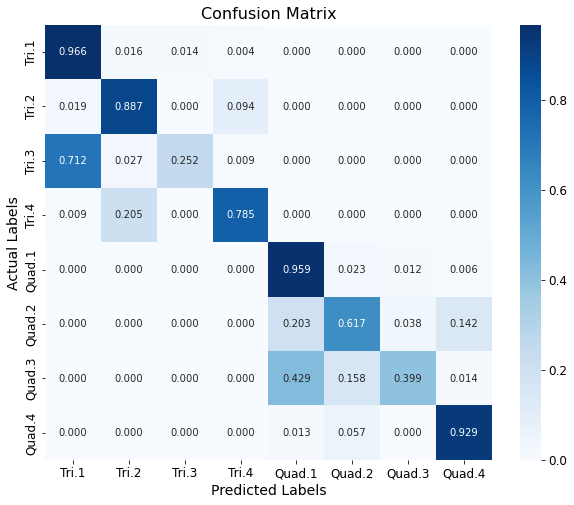

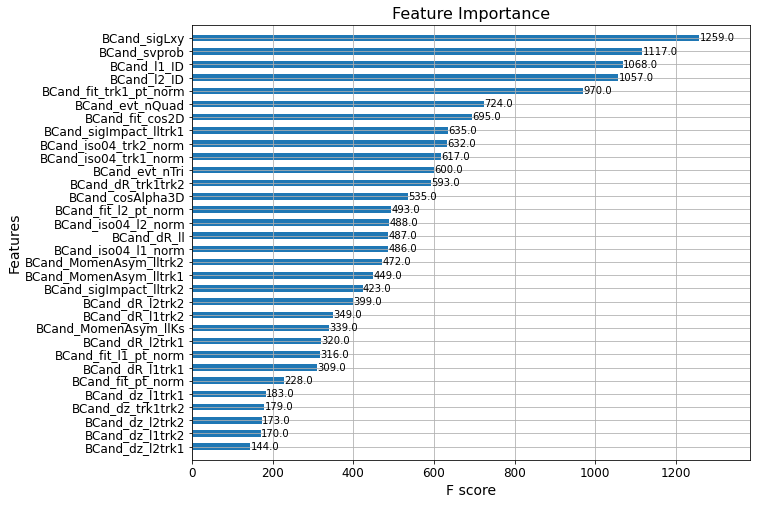

In [21]:
# Predict the labels of the test set
y_pred = bst.predict(dtest)
print(len(y_pred),len(X_test))

# X_train["label_predict"] = y_pred
# X_train["label"] = y_train

# X_train = X_train[X_train['BCand_evt_nQuad'] < 1]
# cm = confusion_matrix(X_train["label"], X_train["label_predict"])

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ticklabels = ["Tri.1","Tri.2","Tri.3","Tri.4","Quad.1","Quad.2","Quad.3","Quad.4"]
# ticklabels = ["Tri.1","Tri.2","Tri.3","Tri.4"]
# ticklabels = ["Tri. C-1","Quad. C-1","Tri. C-2","Quad. C-2","Tri. C-3","Quad. C-3","Tri. C-4","Quad. C-4"]
# ticklabels = ["KEE-1","KsEE-1","KEE-2","KsEE-2","KEE-3","KsEE-3","KEE-4","KsEE-4"]
# ticklabels = ["KEE-1","KEE-2","KEE-3","KEE-4","KsEE-1","KsEE-2","KsEE-3","KsEE-4"]
# ticklabels = ["KEE-1","KEE-2","KEE-4","KsEE-3"]
sns.heatmap(cm, annot=True, fmt=".3f", cmap='Blues', xticklabels=ticklabels, yticklabels=ticklabels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# # Predict the labels of the test set
# y_pred = bst.predict(dtest)

# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# # Plot confusion matrix
# plt.figure(figsize=(10, 8))
# ticklabels = ["KEE-1","KEE-2","KEE-3","KEE-4","KsEE-1","KsEE-2","KsEE-3","KsEE-4"]
# sns.heatmap(cm, annot=True, fmt=".3f", cmap='Blues', xticklabels=ticklabels, yticklabels=ticklabels)
# plt.title('Confusion Matrix')
# plt.ylabel('Actual Labels')
# plt.xlabel('Predicted Labels')
# plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax = xgb.plot_importance(bst,ax=ax,height=0.5)
plt.title('Feature Importance')
plt.show()

# class_report = classification_report(y_test, y_pred)
# print("Classification Report:")
# print(class_report)

664142 664142


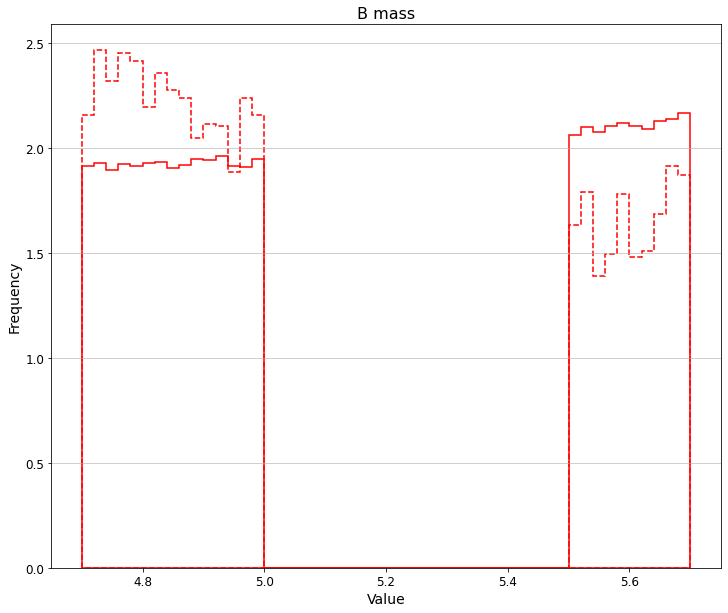

In [103]:
X = X_testforplot
print(len(y_pred),len(X))
X["label_predict"] = y_pred
plt.figure(figsize=(12, 10))
plt.hist(X[X["label"] == 3]['BCand_mass_fullfit'], bins=50, range=(4.7,5.7), log=False, density=True, edgecolor="r", linewidth=1.5,facecolor='none',histtype='stepfilled')
plt.hist(X[(X["label"] == 3) & (X["label_predict"] == 0)]['BCand_mass_fullfit'], bins=50, range=(4.7,5.7), log=False, density=True, edgecolor="r", linestyle='dashed', linewidth=1.5,facecolor='none',histtype='stepfilled')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of y_label')
plt.grid(axis='y', alpha=0.75)
plt.title('B mass')
# plt.ylim(0.1, 100000)
plt.show()

0
1


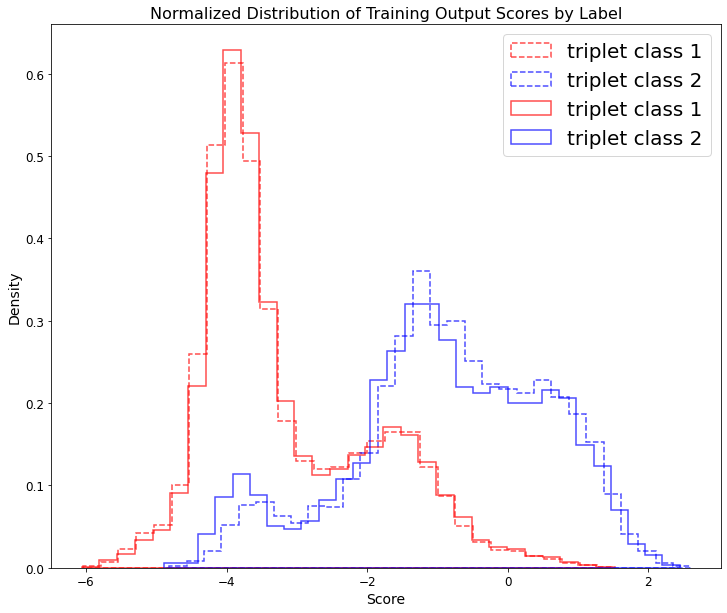

In [15]:
# binary
# Define the DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',  # Change to binary logistic objective for binary classification
    'max_depth': 4,  # Depth of the trees, can be adjusted based on the complexity of your data
    'learning_rate': 0.1,  # Step size shrinkage used to prevent overfitting, can be fine-tuned
    'seed': 42,  # For reproducibility, ensures that your results are the same each time you run your script
    # Optional parameters for binary classification:
    # 'eval_metric': 'logloss',  # Evaluation metric for validation data, common choice is log loss for binary classification
}

# Additional parameters for the training
num_rounds = 70

bst = xgb.train(params, dtrain, num_rounds)

# Make predictions on train set
train_scores = bst.predict(dtrain, output_margin=True)

# Convert the DMatrix back to DataFrame
df_train = pd.DataFrame(dtrain.get_label(), columns=['label'])
df_train['score'] = train_scores

# Make predictions on test set
test_scores = bst.predict(dtest, output_margin=True)

# Convert the DMatrix back to DataFrame
df_test = pd.DataFrame(dtest.get_label(), columns=['label'])
df_test['score'] = test_scores

train_scores_labels = []
test_scores_labels = []
for iclass in range(0,2):
    # Segment scores based on label
    train_scores_labels.append(df_train[df_train['label'] == iclass]['score'])
    test_scores_labels.append(df_test[df_test['label'] == iclass]['score'])

color = ["r","b"]

# Plotting distributions
plt.figure(figsize=(12, 10))
for i, train_scores_label in enumerate(train_scores_labels):
    print(i)
    plt.hist(train_scores_label, bins=30, density=True, alpha=0.7, label=f'triplet class {i+1}', 
         edgecolor=color[i], linewidth=1.5, linestyle='dashed',facecolor='none',histtype='stepfilled')
        
for i, test_scores_label in enumerate(test_scores_labels):
    plt.hist(test_scores_label, bins=30, density=True, alpha=0.7, label=f'triplet class {i+1}', 
         edgecolor=color[i], linewidth=1.5,facecolor='none',histtype='stepfilled')

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Normalized Distribution of Training Output Scores by Label')
plt.legend()
plt.show()

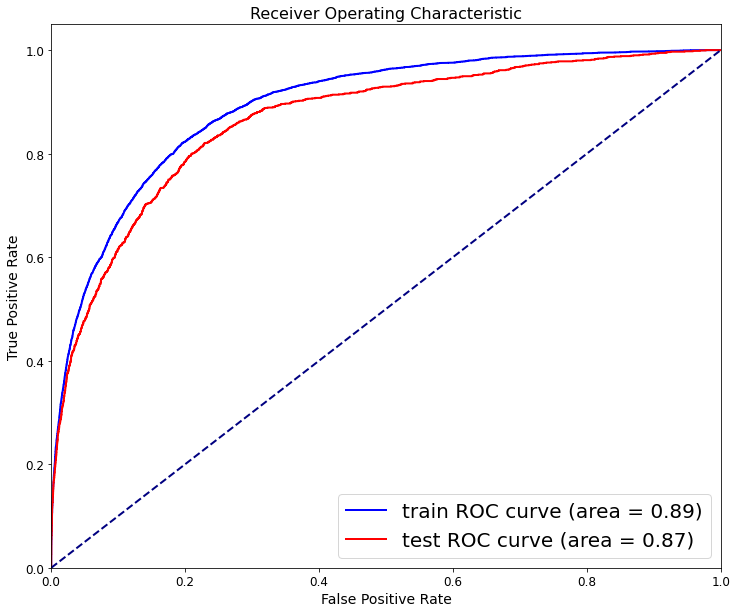

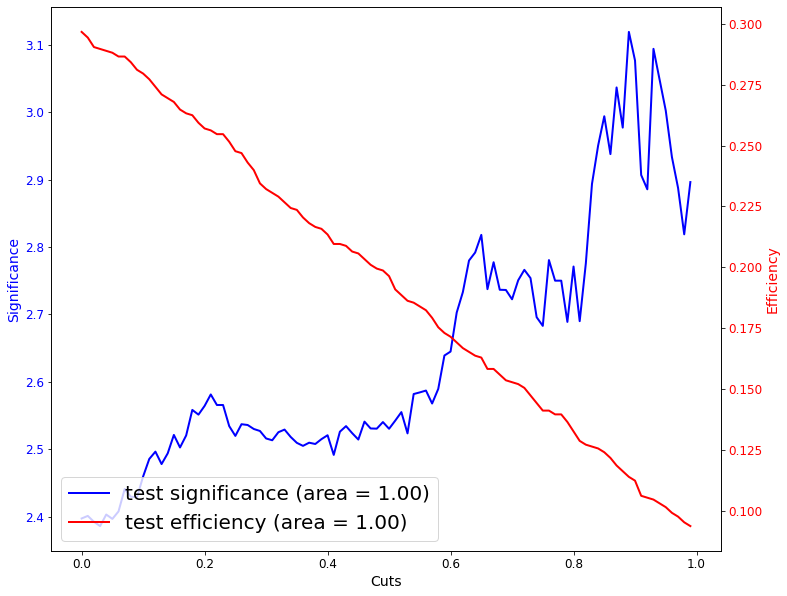

In [16]:
# Concatenate the scores from both classes and the true labels
train_scores_label_0 = train_scores_labels[0]
train_scores_label_1 = train_scores_labels[1]
test_scores_label_0 = test_scores_labels[0]
test_scores_label_1 = test_scores_labels[1]
train_scores = np.concatenate([train_scores_label_0, train_scores_label_1])
train_labels = np.concatenate([np.zeros(len(train_scores_label_0)), np.ones(len(train_scores_label_1))])
test_scores = np.concatenate([test_scores_label_0, test_scores_label_1])
test_labels = np.concatenate([np.zeros(len(test_scores_label_0)), np.ones(len(test_scores_label_1))])

# Compute ROC curve and ROC area
train_fpr, train_tpr, _ = roc_curve(train_labels, train_scores)
train_roc_auc = auc(train_fpr, train_tpr)
test_fpr, test_tpr, _ = roc_curve(test_labels, test_scores)
test_roc_auc = auc(test_fpr, test_tpr)

# Plot ROC curve
plt.figure(figsize=(12, 10))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label='train ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot(test_fpr, test_tpr, color='red', lw=2, label='test ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cuts = np.arange(0, 1, 0.01)
sig_num = [np.sum(np.sort(test_scores_label_1) > value) for value in cuts] 
sig_den = [np.sum(np.sort(test_scores_label_0) > value) for value in cuts] 
sig = np.array(sig_num/np.sqrt(sig_den) / (len(test_scores_label_1) / ROOT.TMath.Sqrt(len(test_scores_label_0))))
eff = np.array(sig_num) / float(len(test_scores_label_1))

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot the first curve on ax1
ax1.plot(cuts, sig, color='blue', lw=2, label='test significance (area = %0.2f)' % 1)
ax1.set_xlabel('Cuts')
ax1.set_ylabel('Significance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create ax2 that shares the same x-axis as ax1
ax2 = ax1.twinx()

# Plot the second curve on ax2
ax2.plot(cuts, eff, color='red', lw=2, label='test efficiency (area = %0.2f)' % 1)
ax2.set_ylabel('Efficiency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend with a combined list of handles from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left')

# Show the plot
plt.show()

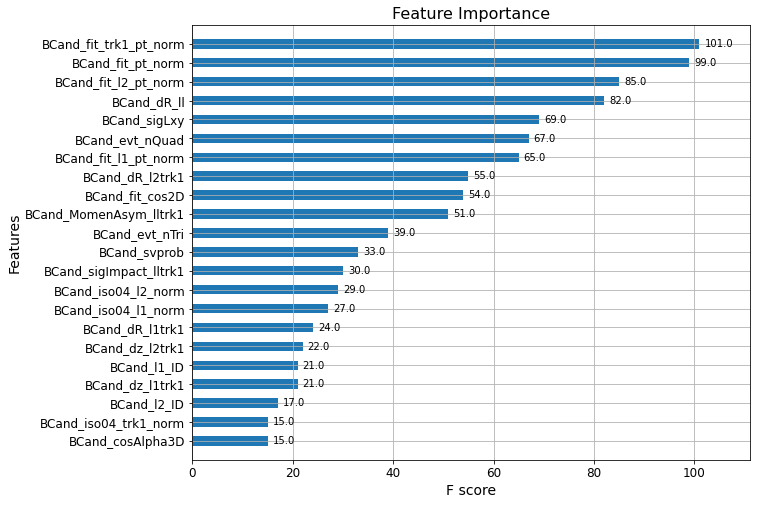

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = xgb.plot_importance(bst,ax=ax,height=0.5)
plt.title('Feature Importance')
plt.show()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')  # Change this layer for multiclass classification
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use this if your labels are integers
              metrics=['accuracy'])
# Train the model and save the history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
predicted_classes = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(predicted_classes, axis=-1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ticklabels = ["Tri. C-1","Tri. C-2","Tri. C-3","Tri. C-4","Quad. C-1","Quad. C-2","Quad. C-3","Quad. C-4"]
sns.heatmap(cm, annot=True, fmt=".3f", cmap='Blues', xticklabels=ticklabels, yticklabels=ticklabels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax = xgb.plot_importance(bst,ax=ax,height=0.5)
plt.title('Feature Importance')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

In [ ]:
test_predicted_scores = model.predict(X_test)
train_predicted_scores = model.predict(X_train)
# Separate the scores based on the actual labels
train_scores_label_0 = train_predicted_scores[y_train == 0]
train_scores_label_1 = train_predicted_scores[y_train == 1]
test_scores_label_0 = test_predicted_scores[y_test == 0]
test_scores_label_1 = test_predicted_scores[y_test == 1]

# Plotting
plt.figure(figsize=(12, 10))
plt.hist(train_scores_label_0, bins=30, density=True, alpha=0.7, label='K0*ee train', 
         edgecolor='blue', linewidth=1.5, linestyle='dashed',facecolor='none',histtype='stepfilled')
plt.hist(train_scores_label_1, bins=30, density=True, alpha=0.7, label='Kee train', 
         edgecolor='red', linewidth=1.5, linestyle='dashed', facecolor='none',histtype='stepfilled')
plt.hist(test_scores_label_0, bins=30, density=True, alpha=0.7, label='K0*ee test', 
         edgecolor='blue', linewidth=1.5, facecolor='none',histtype='stepfilled')
plt.hist(test_scores_label_1, bins=30, density=True, alpha=0.7, label='Kee test', 
         edgecolor='red', linewidth=1.5, facecolor='none',histtype='stepfilled')

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Normalized Distribution of Training Output Scores by Label')
plt.legend()
plt.show()

In [ ]:
# Concatenate the scores from both classes and the true labels
train_scores = np.concatenate([train_scores_label_0, train_scores_label_1])
train_labels = np.concatenate([np.zeros(len(train_scores_label_0)), np.ones(len(train_scores_label_1))])
test_scores = np.concatenate([test_scores_label_0, test_scores_label_1])
test_labels = np.concatenate([np.zeros(len(test_scores_label_0)), np.ones(len(test_scores_label_1))])

# Compute ROC curve and ROC area
train_fpr, train_tpr, _ = roc_curve(train_labels, train_scores)
train_roc_auc = auc(train_fpr, train_tpr)
test_fpr, test_tpr, _ = roc_curve(test_labels, test_scores)
test_roc_auc = auc(test_fpr, test_tpr)

# Plot ROC curve
plt.figure(figsize=(12, 10))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label='train ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot(test_fpr, test_tpr, color='red', lw=2, label='test ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cuts = np.arange(0, 1, 0.01)
sig_num = [np.sum(np.sort(test_scores_label_1) > value) for value in cuts] 
sig_den = [np.sum(np.sort(test_scores_label_0) > value) for value in cuts] 
sig = np.array(sig_num/np.sqrt(sig_den) / (len(test_scores_label_1) / ROOT.TMath.Sqrt(len(test_scores_label_0))))
eff = np.array(sig_num) / float(len(test_scores_label_1))

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot the first curve on ax1
ax1.plot(cuts, sig, color='blue', lw=2, label='test significance')
ax1.set_xlabel('Cuts')
ax1.set_ylabel('Significance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create ax2 that shares the same x-axis as ax1
ax2 = ax1.twinx()

# Plot the second curve on ax2
ax2.plot(cuts, eff, color='red', lw=2, label='test efficiency')
ax2.set_ylabel('Efficiency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend with a combined list of handles from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left')

# Show the plot
plt.show()